# Importando los modulos necesarios

In [1]:
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

sns.set(style='ticks',
        palette='muted',
        context='notebook')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Importando la data

In [2]:
beta_matrix = pd.read_table('../data/hg19_beta.matrix.gz')
annot_file = pd.read_table('../data/hg19_segmented.annot.bed.gz', header=None)


## Usa solo las regiones que estan asociados a genes

In [3]:
annot_file.dropna(inplace = True)

In [4]:
beta_matrix = beta_matrix.iloc[annot_file.index, :]

Cambiar el nombre de las columnas en `annot_file` para despues usarlo con facilidad


In [5]:
annot_file.columns = ['chr', 'start', 'end', 'startCpG', 'endCpG', 'type', 'gene']

## Breve inspeccion de la data

Inspecciona la data para confirmar que esta completa

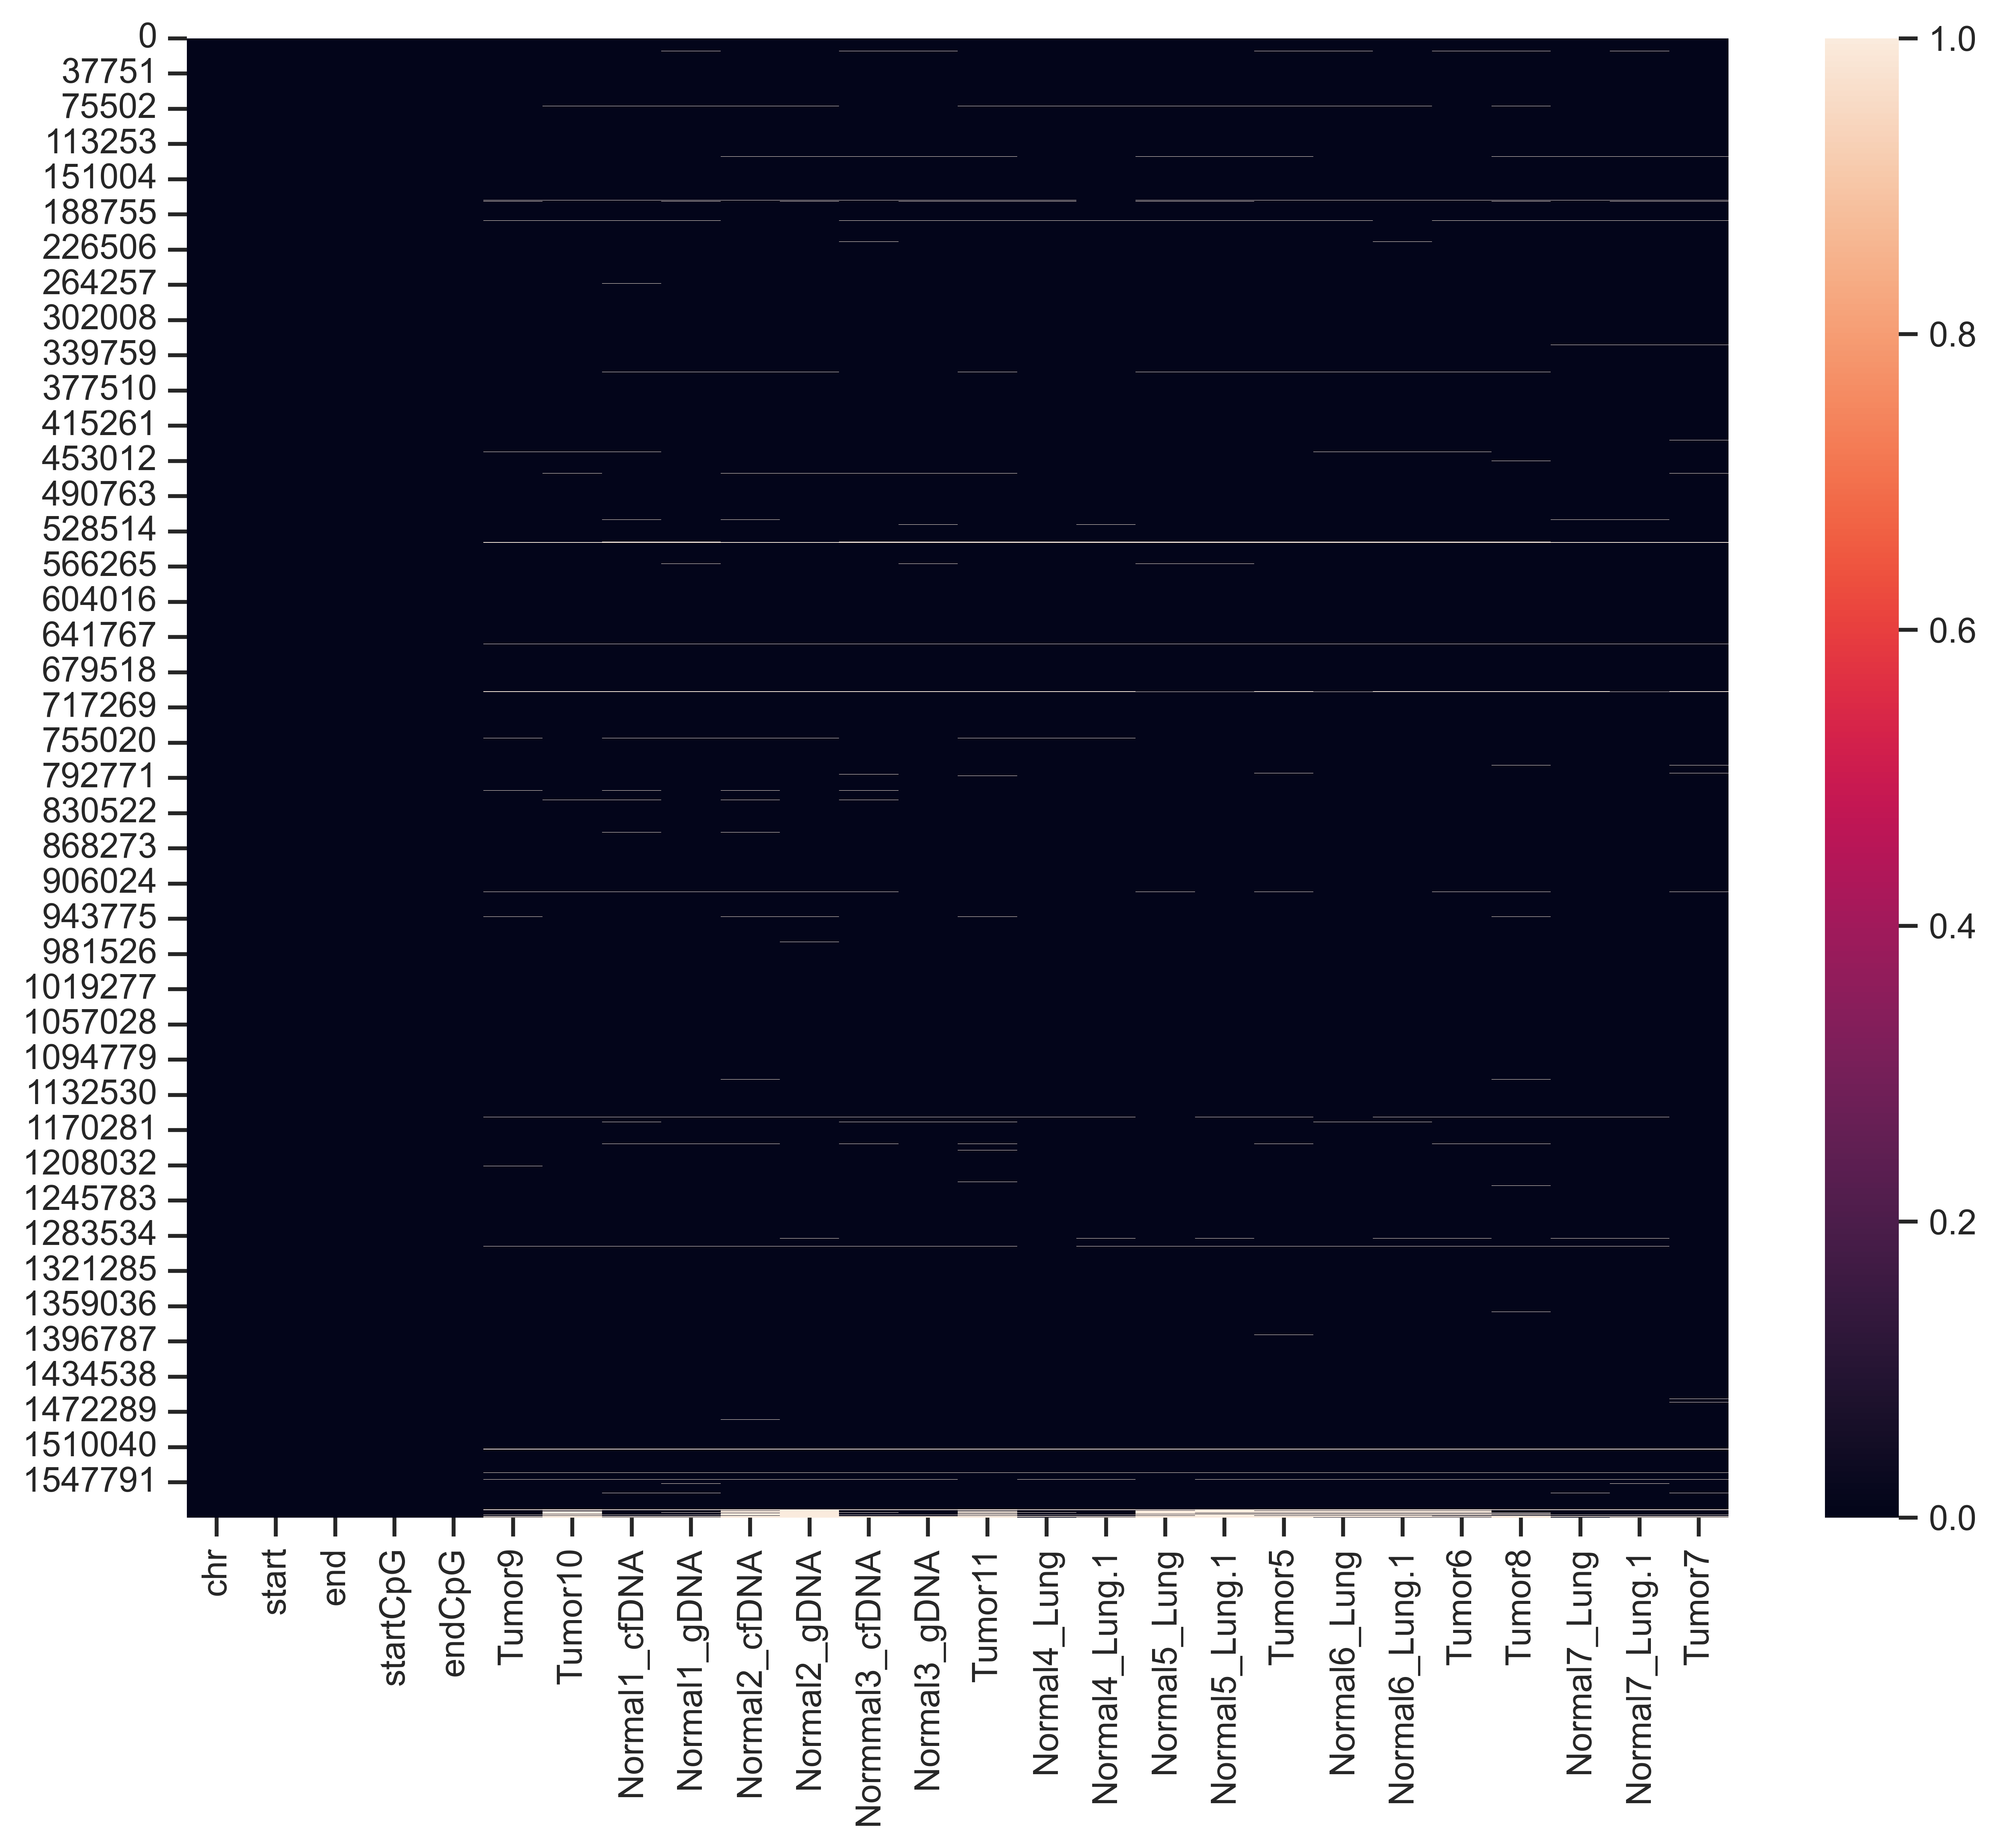

In [6]:
plt.figure(figsize=(11, 8.5))

sns.heatmap(beta_matrix.isna(), vmin = 0, vmax = 1)
plt.show()

Llenar las filas con data incompleta usando `data.fillna()`

In [7]:
beta_matrix.fillna(0.5, inplace=True)

Volver a verificar que ya no hay datos incompletas

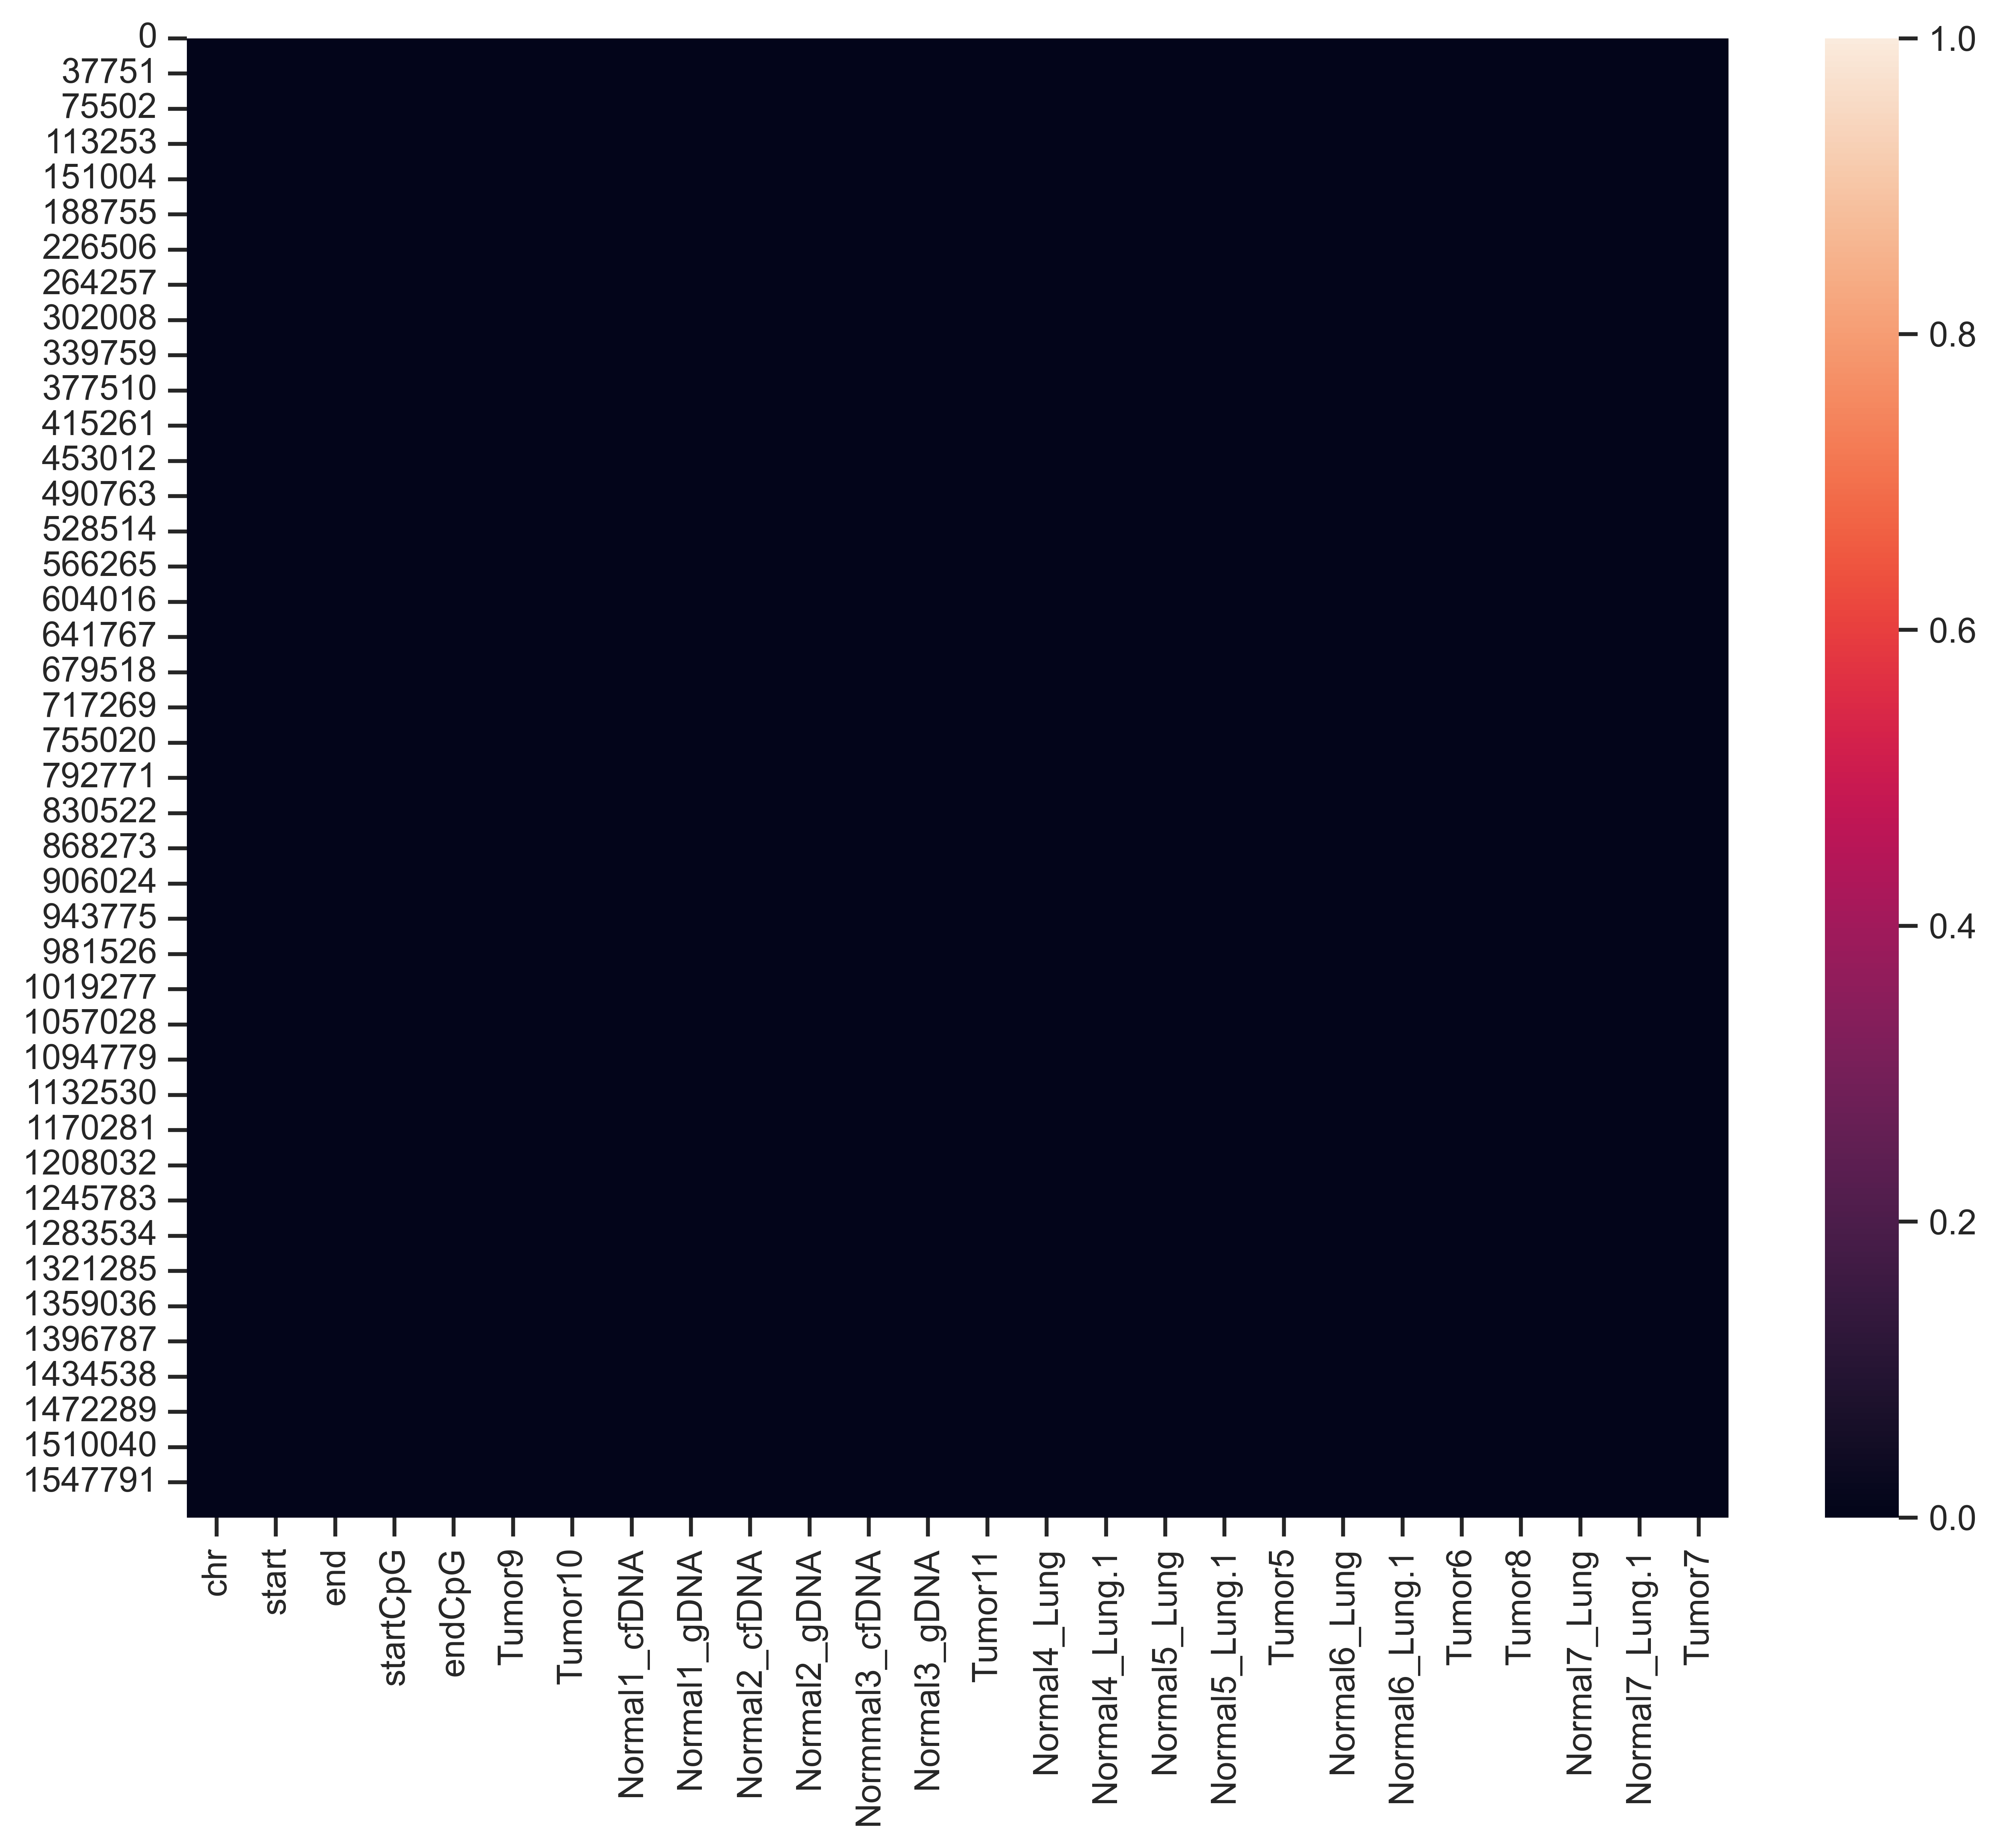

In [8]:
plt.figure(figsize=(11, 8.5))

sns.heatmap(beta_matrix.isna(), vmin = 0, vmax = 1)
plt.show()

# Identificacion de las regiones differentes entre tumor y normal 

Seleccionar las muestras normales y de tumores

In [9]:
normal_matrix = beta_matrix.loc[: , beta_matrix.columns.str.contains('Normal')]
tumor_matrix = beta_matrix.loc[: , beta_matrix.columns.str.contains('Tumor')]

Encontrar la diferencia promedia entre los normales y tumores

In [10]:
differencia_promedia = np.mean(tumor_matrix, axis = 1) - np.mean(normal_matrix, axis = 1)

Encontar cual de las regiones son significamente differentes usando estadistica

In [11]:
stat, p = sp.stats.mannwhitneyu(tumor_matrix, normal_matrix, axis = 1)

In [12]:
qval = sp.stats.false_discovery_control(p)

Añadir los resultados (la diferencia promedia normal v. tumor, y las estadisticas) al `annot_file` para filtrar por las regiones importantes

In [13]:
annot_file['diff_tumor_normal'] = differencia_promedia
annot_file['qval'] = qval

## Regiones diferentes entre tumor vs. normal

Filtrar por las regiones (filas) que son significantemente differentes entre tumor vs. normal

In [14]:
reg_sig = annot_file[(annot_file['qval'] <= 0.05) & (np.abs(annot_file['diff_tumor_normal']) > 0.50) & (annot_file['type'].str.contains(r'promoter|TSS'))]

/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dalmanza/anaconda3/envs/CdeC_Peru/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 3300x2550 with 0 Axes>

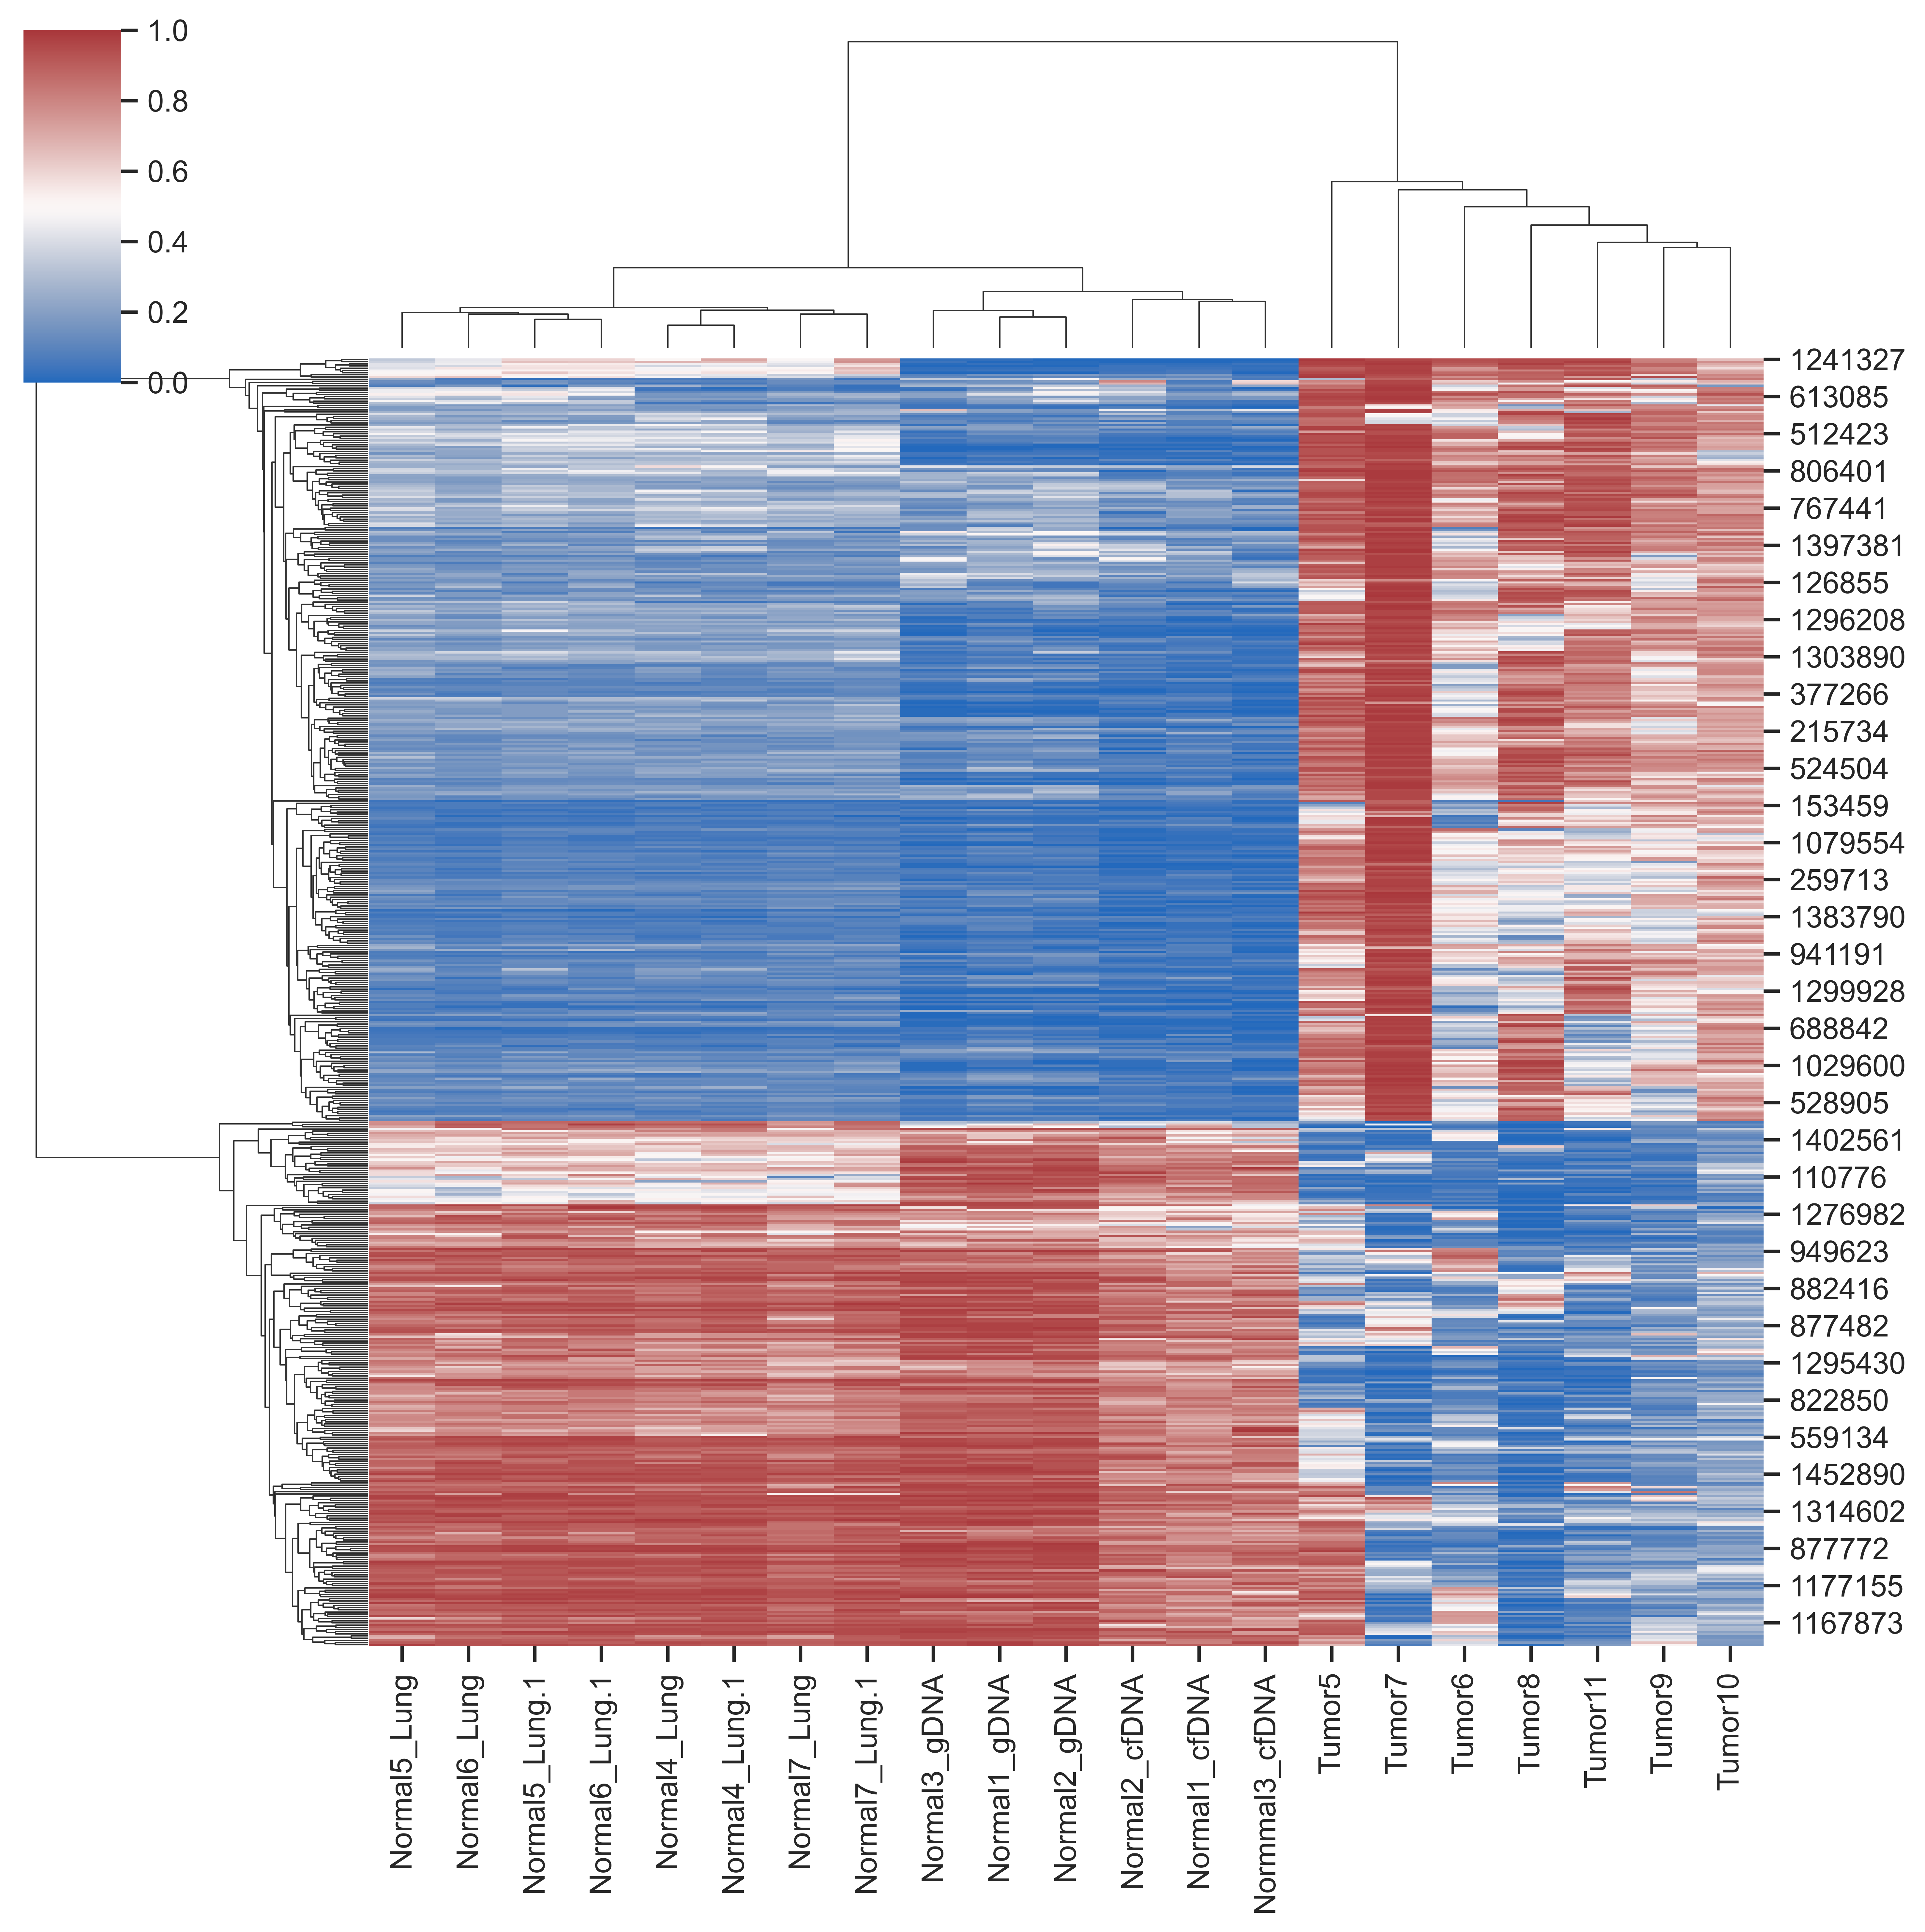

In [15]:
plt.figure(figsize=(11, 8.5))

sns.clustermap(
    beta_matrix.iloc[reg_sig.index, 5::],
    cmap = 'vlag',
    center = 0.5
)
plt.show()

### Regiones de hipermetilacion

Filtrar por las regiones (filas) que son hipermetiladas significantemente differentes entre tumor vs. normal

In [16]:
reg_sig_hyper = annot_file[(annot_file['qval'] <= 0.05) & (annot_file['diff_tumor_normal'] >= 0.50) & (annot_file['type'].str.contains(r'promoter|TSS'))]

<Figure size 3300x2550 with 0 Axes>

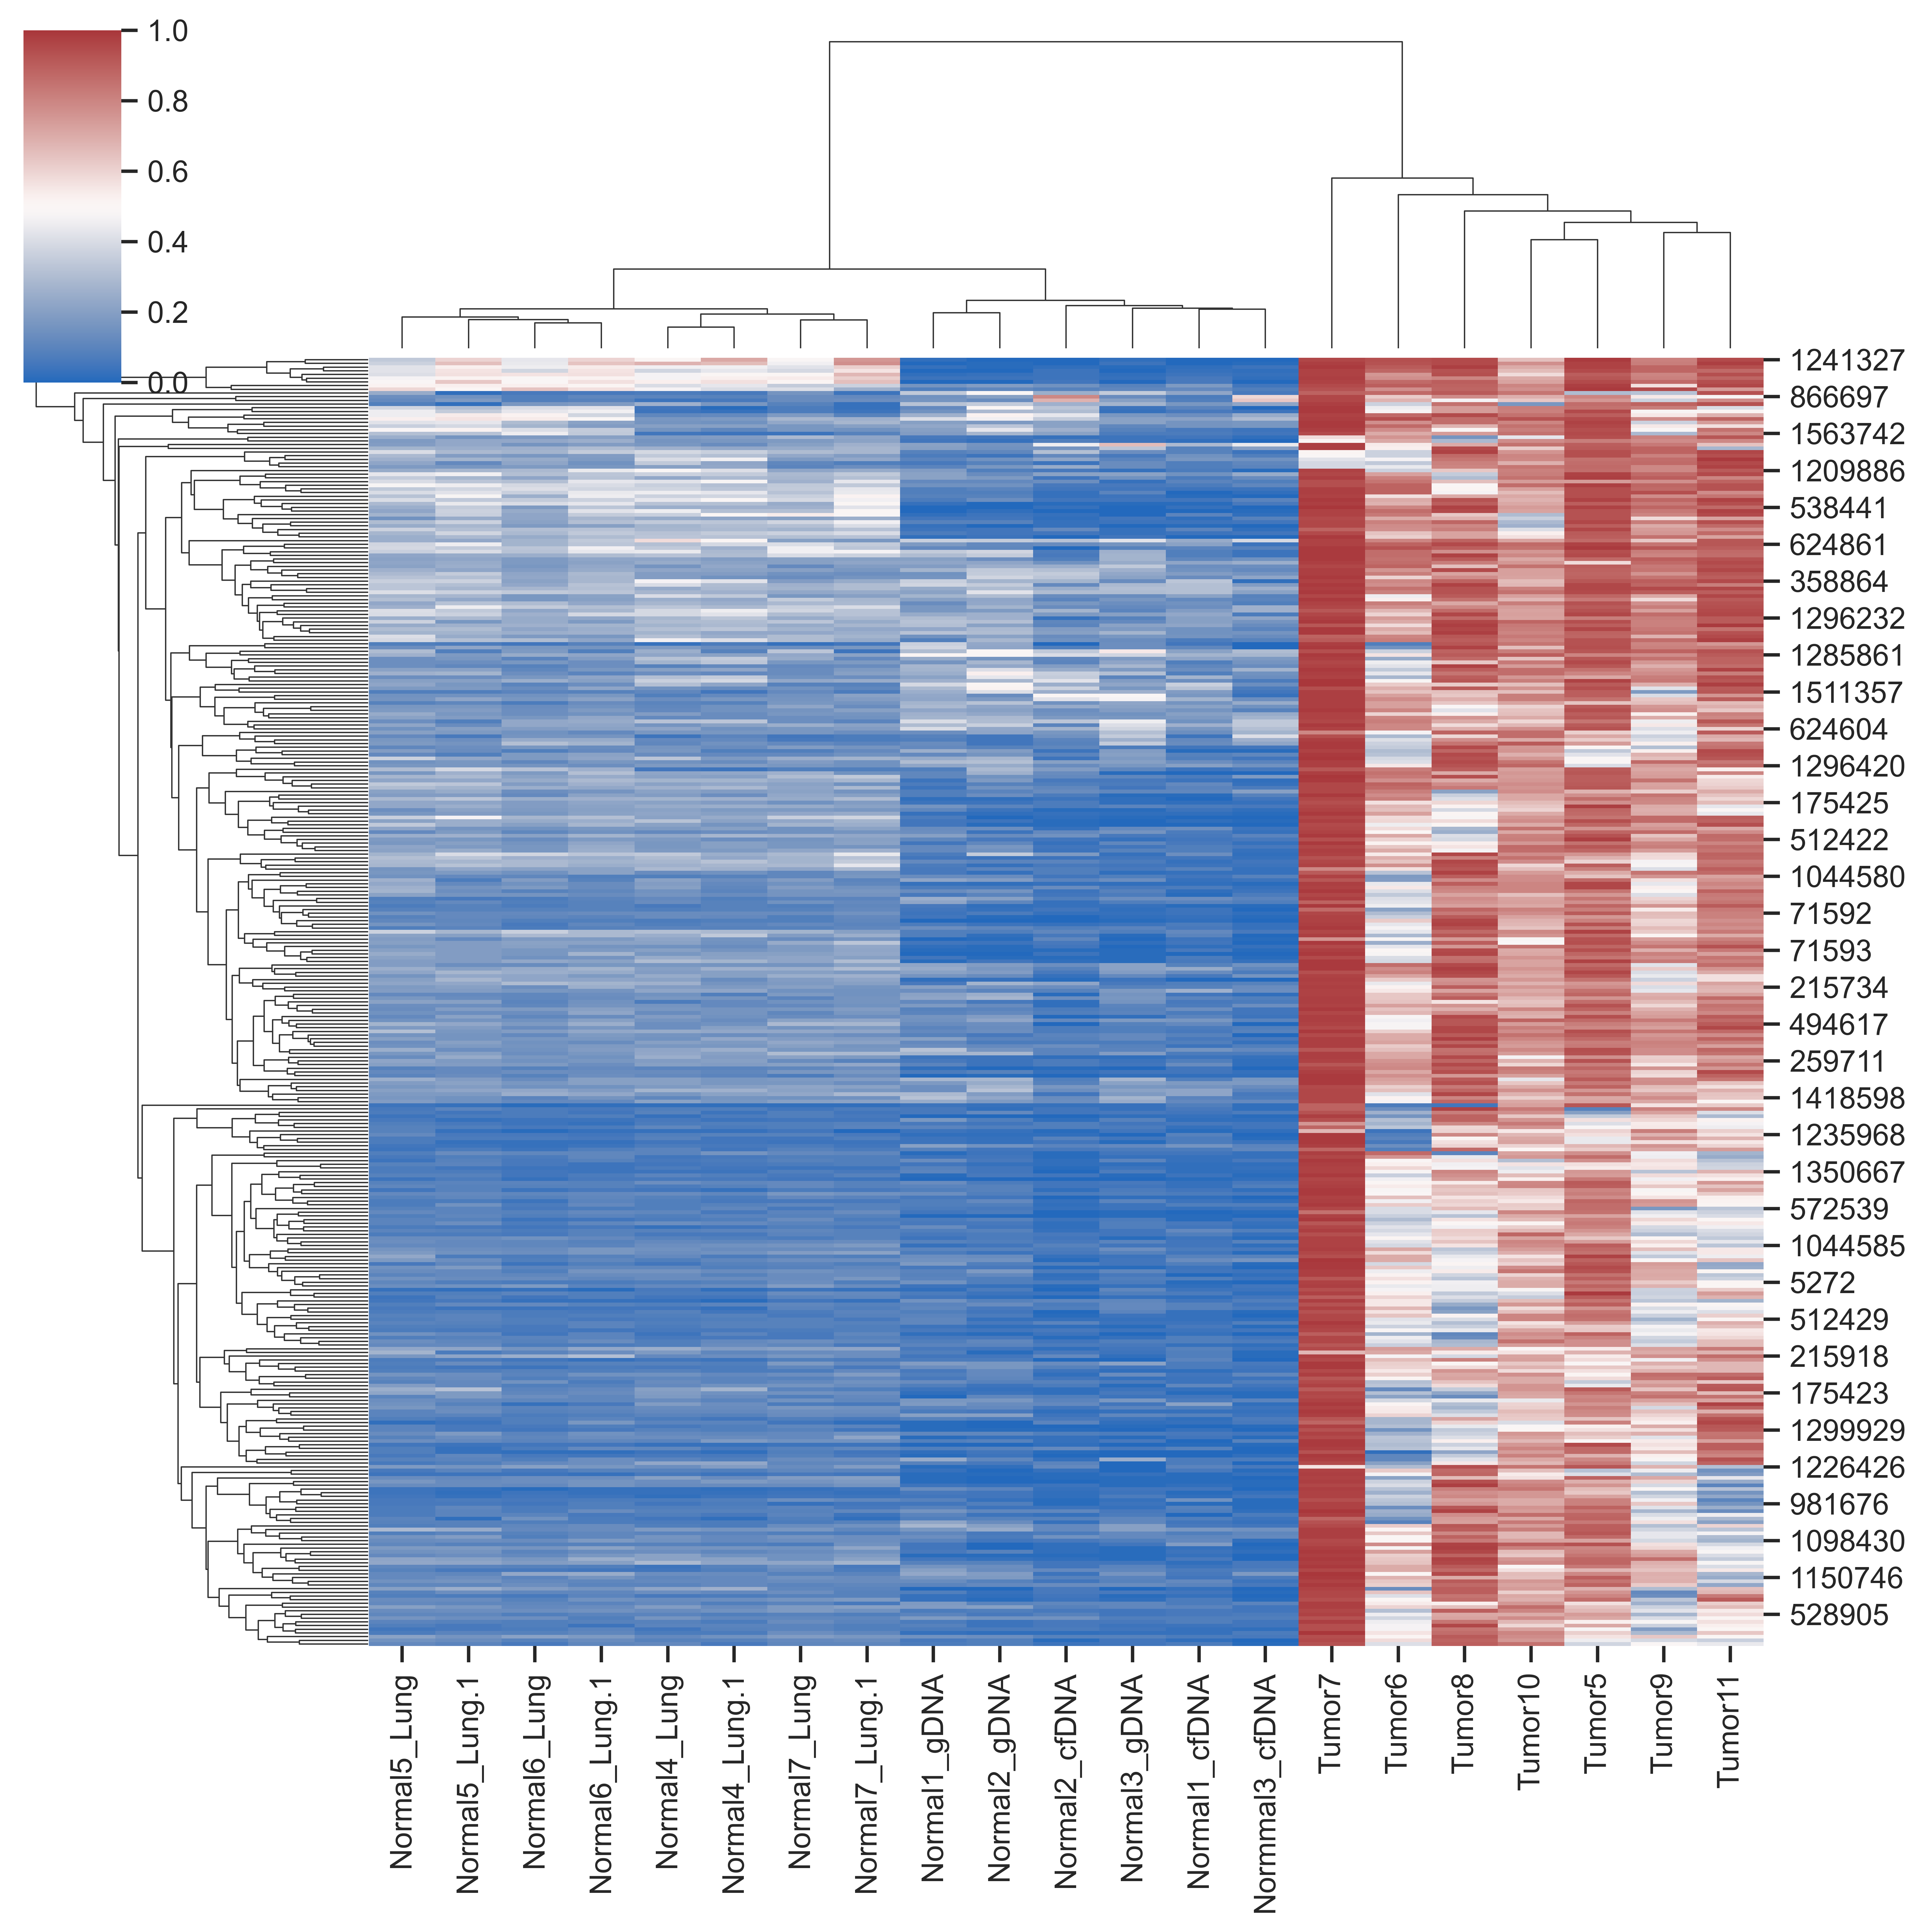

In [17]:
plt.figure(figsize=(11, 8.5))

sns.clustermap(
    beta_matrix.iloc[reg_sig_hyper.index, 5::],
    cmap = 'vlag',
    center = 0.5
)
plt.show()

Exporta los genes hipermetilados

In [18]:
genes = []

for gene in list(set(reg_sig_hyper['gene'])):
    for gene in gene.split(','):
        genes.append(gene)

pd.DataFrame(set(genes)).to_csv('../data/hyper_genes.txt', header=False, index =False)

In [19]:
bg_genes = []

for gene in list(set(annot_file['gene'])):
    for gene in gene.split(','):
        bg_genes.append(gene)
        
pd.DataFrame(set(bg_genes)).to_csv('../data/bg_genes.txt', header=False, index =False)

### Regiones de hipometilacion

Filtrar por las regiones (filas) que son hipormetiladas significantemente differentes entre tumor vs. normal

In [21]:
reg_sig_hipo = annot_file[(annot_file['qval'] <= 0.05) & (annot_file['diff_tumor_normal'] <= -0.50) & (annot_file['type'].str.contains(r'promoter|TSS'))]

<Figure size 3300x2550 with 0 Axes>

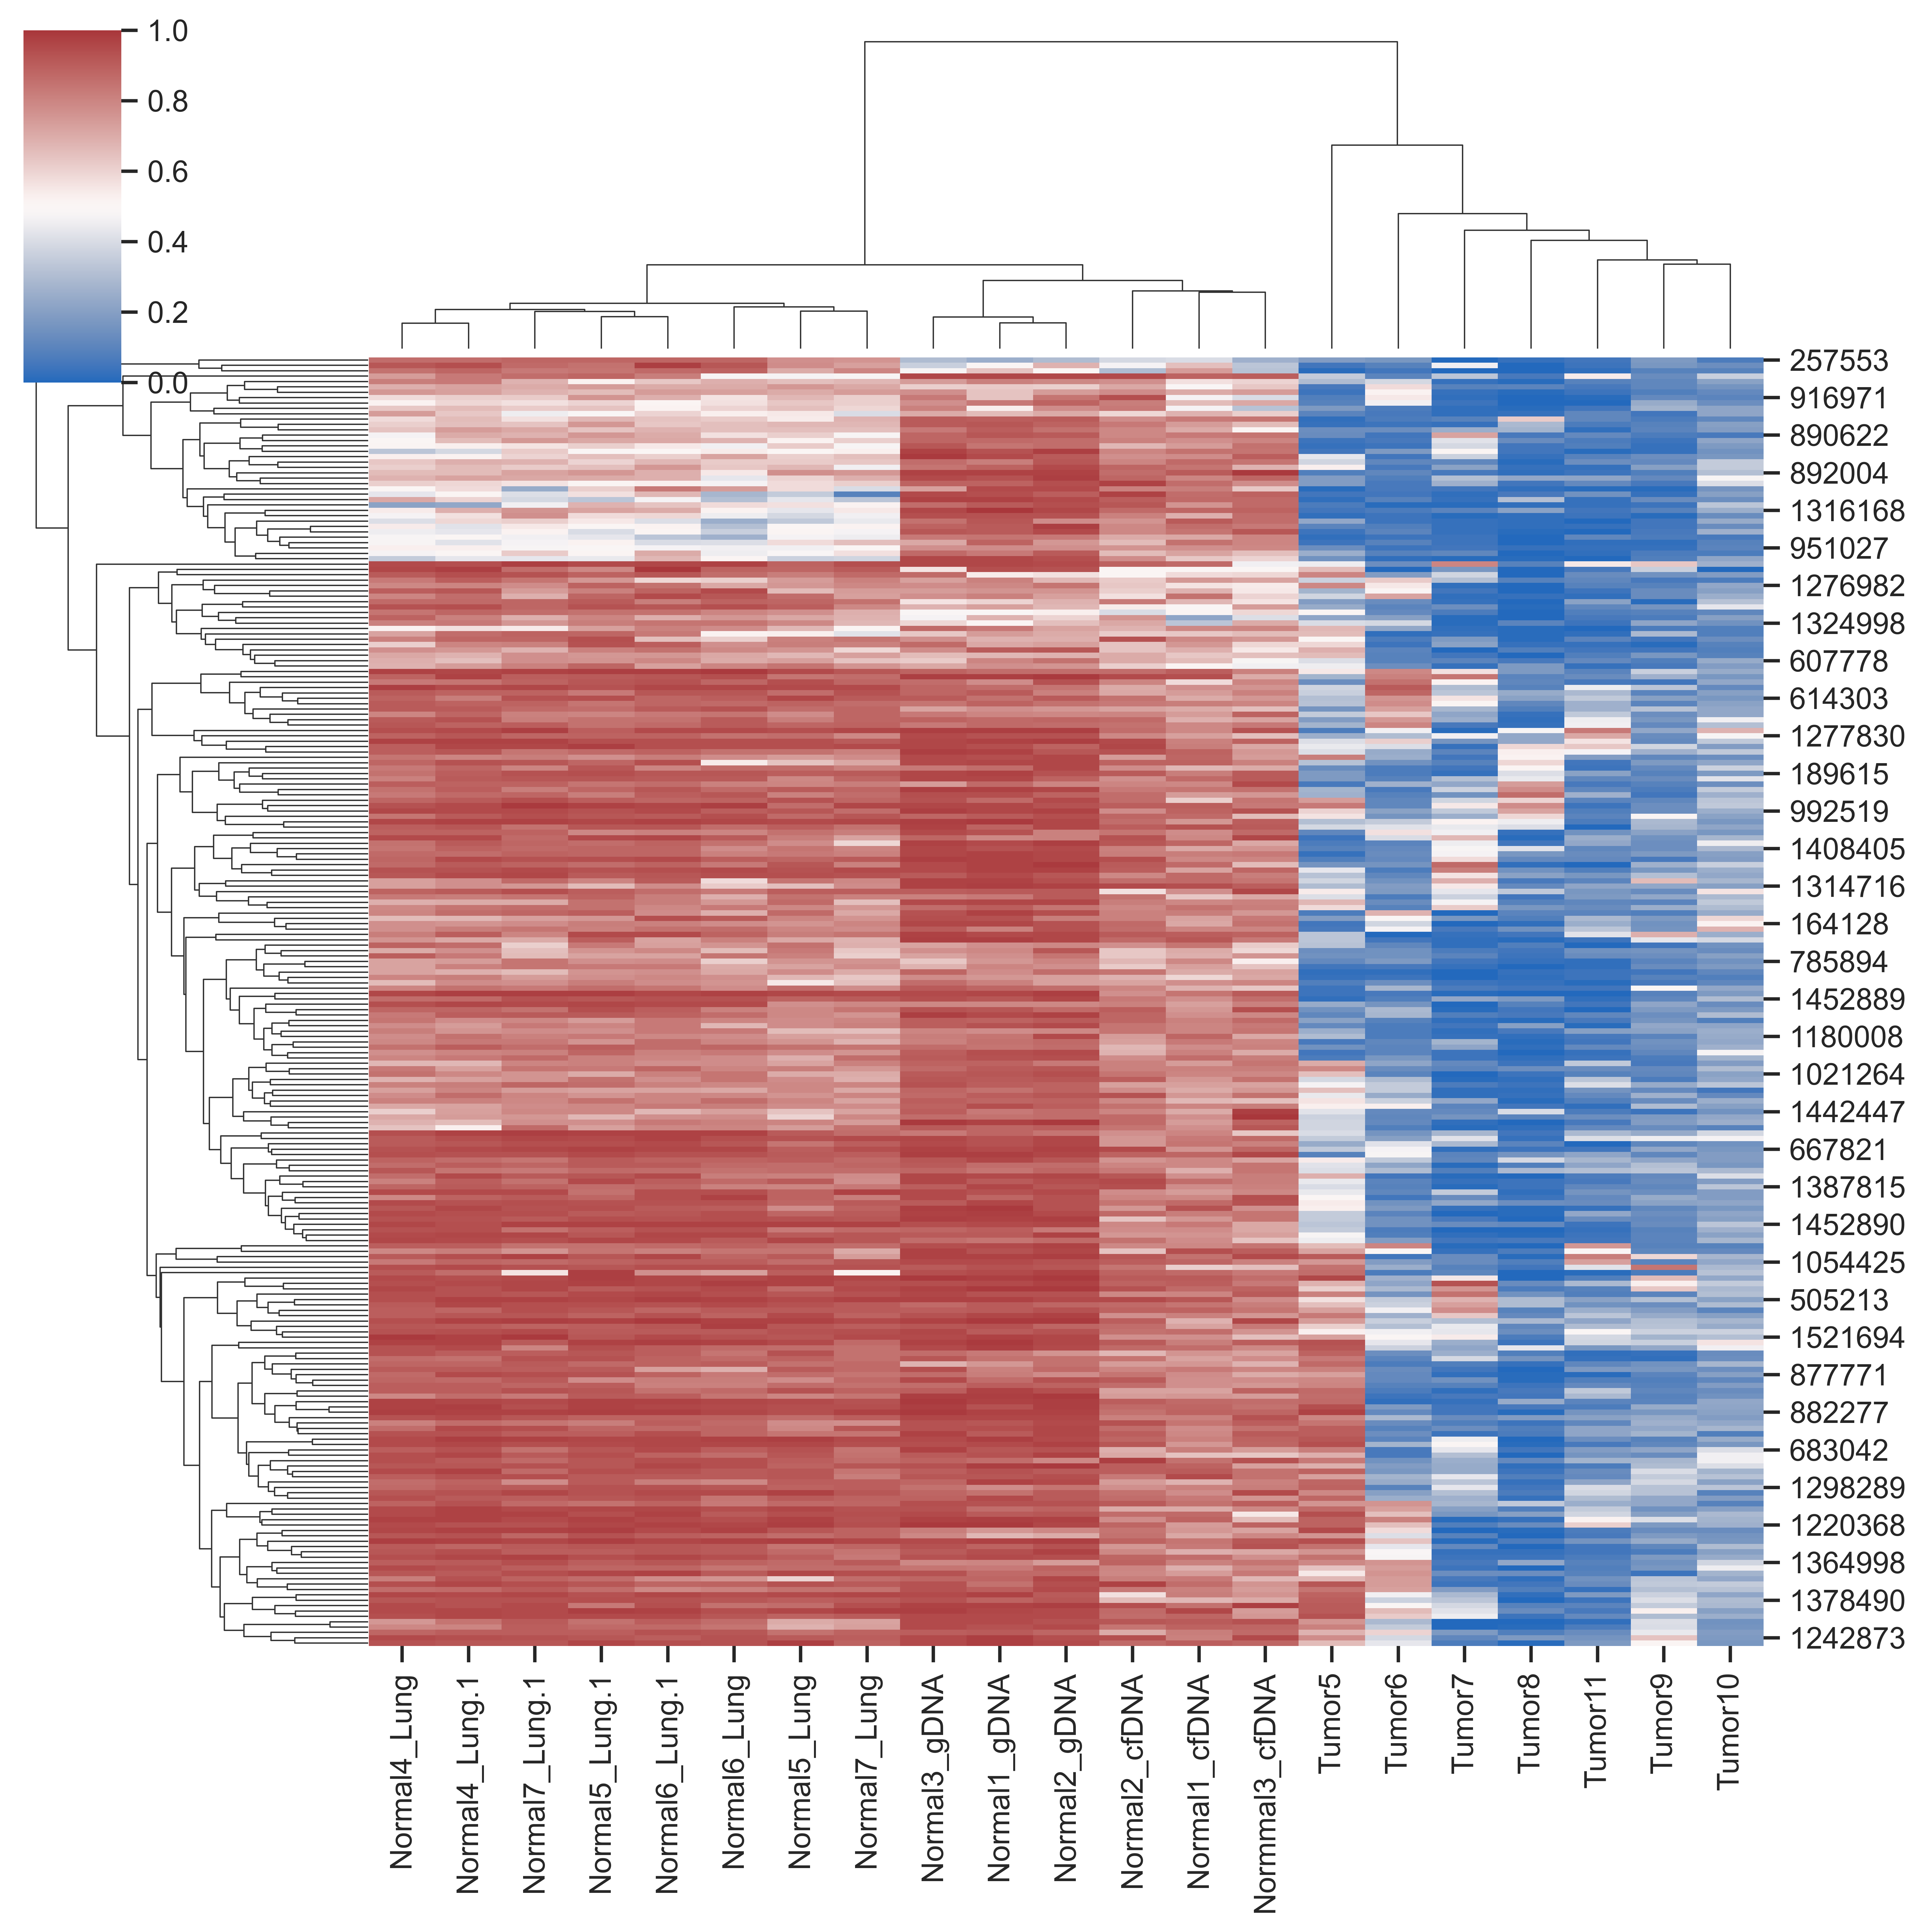

In [22]:
plt.figure(figsize=(11, 8.5))

sns.clustermap(
    beta_matrix.iloc[reg_sig_hipo.index, 5::],
    cmap = 'vlag',
    center = 0.5
)
plt.show()

Exporta los genes hipormetilados

In [23]:
genes = []

for gene in list(set(reg_sig_hipo['gene'])):
    for gene in gene.split(','):
        genes.append(gene)
        
pd.DataFrame(set(genes)).to_csv('../data/hypo_genes.txt', header=False, index =False)